Transfer Learning with CNN


### GPU connection Check

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 29 05:15:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   44C    P0              27W /  72W |   1051MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Check memory availability

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 56.9 gigabytes of available RAM

You are using a high-RAM runtime!


### Import Libraries

In [4]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

# Additional libraries
import numpy as np
import os
import time
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import shutil

# torchvision imports
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder




%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

### Import Data

In [5]:
!git clone https://github.com/jyassien/LPDI.git

Cloning into 'LPDI'...
remote: Enumerating objects: 4787, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4787 (delta 34), reused 33 (delta 11), pack-reused 4707 (from 1)
Receiving objects: 100% (4787/4787), 530.33 MiB | 13.96 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Updating files: 100% (4721/4721), done.


## Load Model

In [29]:
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# num_classes = 8  # 8 variant classififcations of plants
# model.fc = nn.Linear(model.fc.in_features, num_classes)

## Allocate GPU for the model

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# print out which device is being used
print(f"Using device: {device}")

Using device: cuda


Load Data
=========


In [31]:
# Data augmentation and normalization for training
# Just normalization for
from torchvision import datasets, transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/LPDI/server/data/tomato/Variant_A'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


Examples of training images:
======================

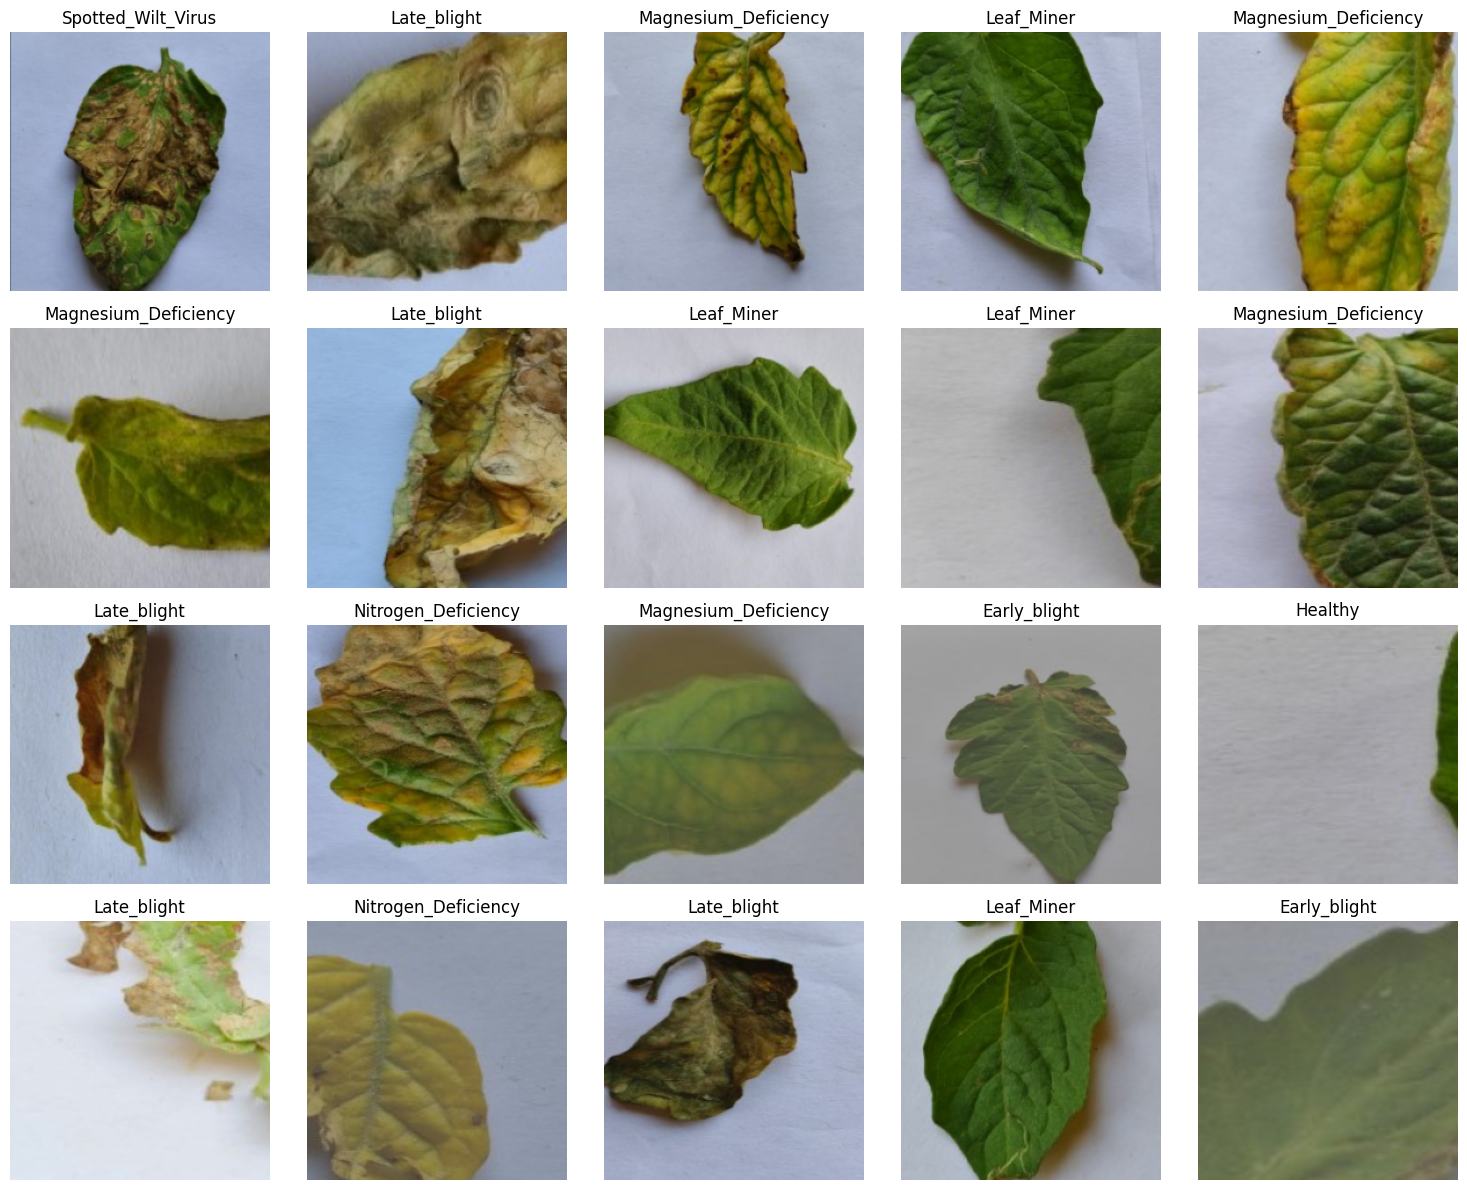

In [32]:
def imshow_grid(inputs, classes, class_names, num_rows=4):
    """Display images in a grid with class names above each image."""
    batch_size = inputs.size(0)
    inputs = inputs.cpu()  # matplotlib compatibility

    num_columns = batch_size // num_rows if batch_size % num_rows == 0 else (batch_size // num_rows) + 1

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))
    axes = axes.flatten()

    for idx, ax in enumerate(axes):
        if idx < batch_size:
            inp = inputs[idx].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            ax.imshow(inp)
            ax.set_title(class_names[classes[idx]], fontsize=12)
            ax.axis("off")
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

training_examples = imshow_grid(inputs, classes, class_names, num_rows=4)


Fine-tuning the pretrained model with ConvNet
=============================================

In [33]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

num_classes = 8  # 8 variant classififcations of plant health

print(f'Original number of input and output features of resnet18 : {model_ft.fc}')


model_ft.fc = nn.Linear(num_ftrs, num_classes)

print(f'Updated number of input and output features of resnet18 :  {model_ft.fc}')


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Original number of input and output features of resnet18 : Linear(in_features=512, out_features=1000, bias=True)
Updated number of input and output features of resnet18 :  Linear(in_features=512, out_features=8, bias=True)


### Model training method

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    b_losses = {'train':[], 'val':[]}
    e_losses = {'train':[], 'val':[]}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}', end="")

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    b_losses[phase].append(loss.item())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                # print loss and accuraacy every 4 epochs
                if epoch % 4 == 0:
                    print(f'\t{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}', end="\t")
                   # print('-' * 10)
                # save loss for plotting later on
                e_losses[phase].append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, e_losses, b_losses

## Train and Evaluate

In [37]:
model_ft, epoch_losses, batch_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 1/25	train Loss: 0.7253 Acc: 0.7274		val Loss: 0.6039 Acc: 0.7871	
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25	train Loss: 0.4713 Acc: 0.8340		val Loss: 0.4269 Acc: 0.8514	
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25	train Loss: 0.3810 Acc: 0.8662		val Loss: 0.3452 Acc: 0.8769	
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25	train Loss: 0.3699 Acc: 0.8637		val Loss: 0.3353 Acc: 0.8858	
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25	train Loss: 0.3485 Acc: 0.8773		val Loss: 0.3374 Acc: 0.8792	
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25	train Loss: 0.3461 Acc: 0.8798		val Loss: 0.3202 Acc: 0.8980	
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25	train Loss: 0.3395 Acc: 0.8884		val Loss: 0.3181 Acc: 0.8925	
Training complete in 2m 30s
Best val Acc: 0.898004


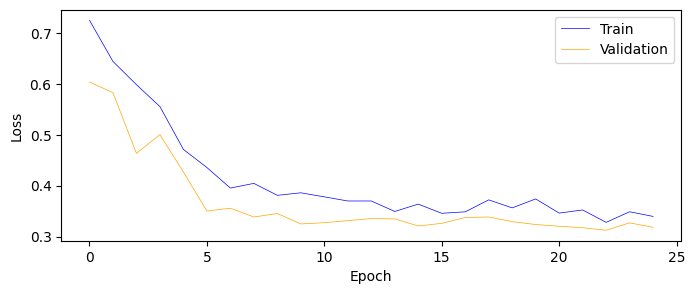

In [41]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

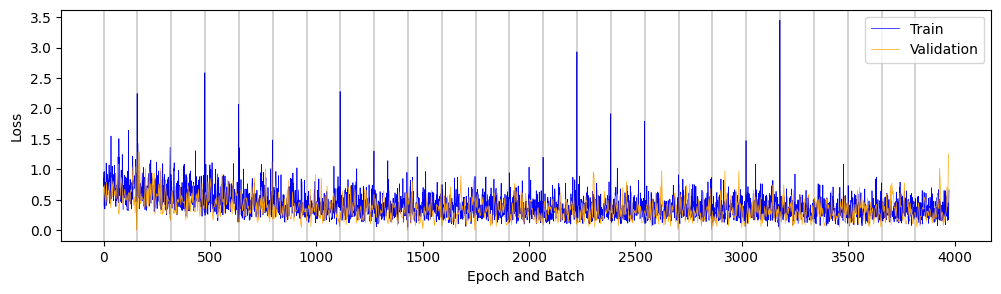

In [42]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

Perform testing on the ConvNet model
==================

In [60]:
def test_model(model, dataloaders, dataset_sizes, split='val', track_batches=False):
    """Evaluate the model on a specific split ('val' or 'test')."""
    model.eval()
    correct = 0
    total = 0
    batch_accuracies = []


    with torch.no_grad():
        for inputs, labels in dataloaders[split]:
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()


            # Track batch accuracy
            if track_batches:
                batch_correct = (preds == labels).sum().item()
                batch_total = labels.size(0)
                batch_acc = 100.0 * batch_correct / batch_total
                batch_accuracies.append(batch_acc)

    # Compute accuracy
    accuracy = 100 * correct / total
    print(f'{split.capitalize()} Accuracy: {accuracy:.2f}%')

    if track_batches:
        return accuracy, batch_accuracies

    return accuracy



# Call the testing function and save the accuracy
accuracy = test_model(model_ft, dataloaders, dataset_sizes, split='test')





Test Accuracy: 89.80%


## Visualizing model *predictions*

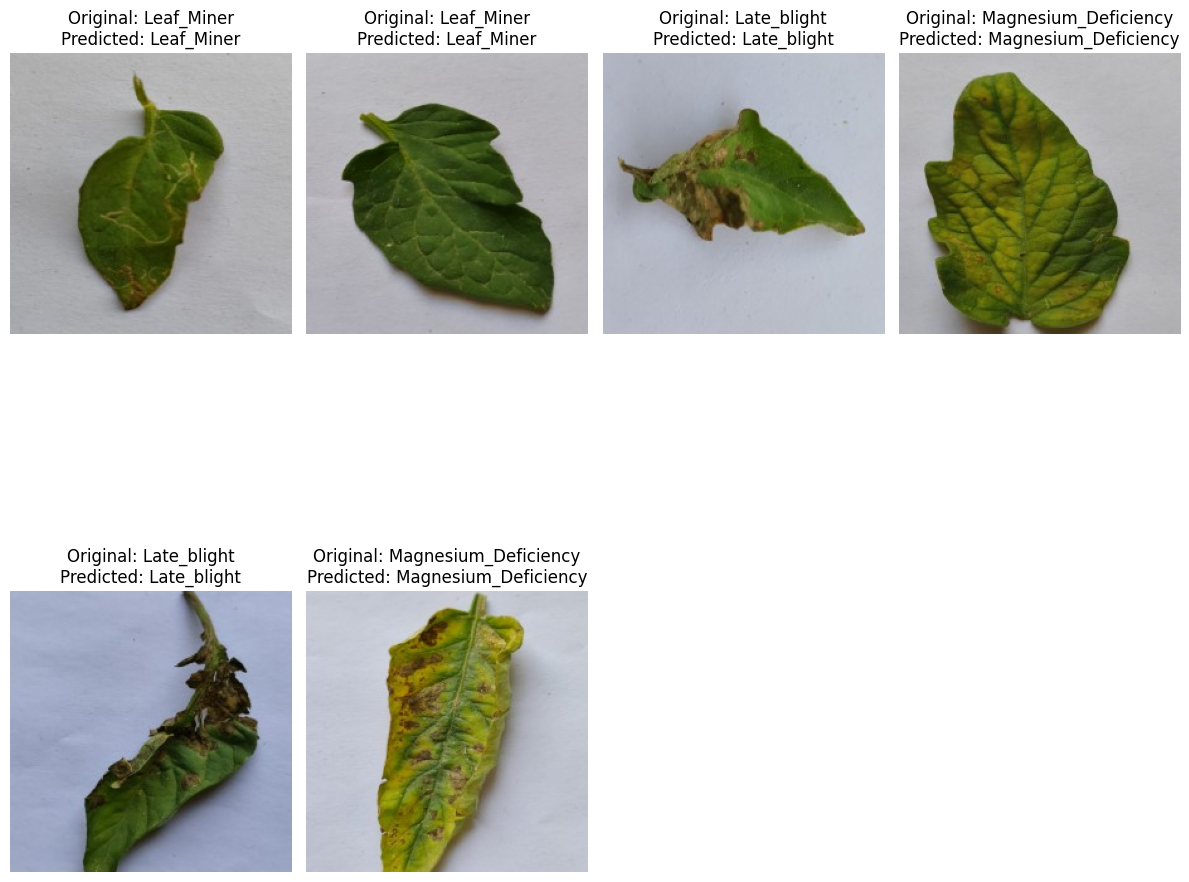

In [64]:
def imshow(inp, ax):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    ax.axis('off')


def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Initialize the figure

    num_rows = (num_images + 3) // 4  # Calculate rows for grid

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            batch_size = inputs.size(0)
            for j in range(batch_size):
                # Check if the label and prediction are within the bounds of class_names
                if labels[j].item() >= len(class_names) or preds[j].item() >= len(class_names):
                    print(f"Skipping label {labels[j].item()} or prediction {preds[j].item()} as it is out of range")
                    continue  # Skip this image if it's out of bounds

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return fig  # Ensure a valid figure is returned

                images_so_far += 1
                row = (images_so_far - 1) // 4
                col = (images_so_far - 1) % 4

                ax = plt.subplot(num_rows, 4, images_so_far)
                ax.set_title(f'Original: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}')

                imshow(inputs.cpu().data[j], ax)

        model.train(mode=was_training)

    plt.tight_layout()
    return fig


figure = visualize_model(model_ft, dataloaders, class_names, num_images=6)





### Save Outputs


In [68]:
folder = '/content/model_summaries'
pdf_name = f'{model.__class__.__name__}_Finetuned_ConvNet_summary.pdf'
pdf_path = os.path.join(folder, pdf_name)

# Ensure the folder exists
if not os.path.exists(folder):
    os.makedirs(folder)


def save_to_pdf(pdf, figure):
    pdf.savefig(figure)
    plt.close(figure)


def save_model_outputs_to_pdf(model, accuracy, figure):

    with PdfPages(pdf_path) as pdf:
        # Validation accuracy
        fig = plt.figure(figsize=(8, 4))
        plt.text(0.5, 0.5, f"Model: {model.__class__.__name__}_Finetuned_ConvNet\nValidation Accuracy: {accuracy:.2f}%",
                 horizontalalignment='center', verticalalignment='center', fontsize=18)
        plt.axis('off')
        save_to_pdf(pdf, fig)

        # Predictions visualization)
        save_to_pdf(pdf, figure)  # Save the figure visualizing predictions

    print(f"Model summary saved to {pdf_path}")


save_model_outputs_to_pdf(model, accuracy, figure)

Model summary saved to /content/model_summaries/ResNet_Finetuned_ConvNet_summary.pdf


# Save to GitHub folder




In [69]:
git_path = f'/content/LPDI/server/model/model_summaries/{pdf_name}'
shutil.copy(pdf_path, git_path)

%cd /content/LPDI



/content/LPDI


### Save to local machine

In [70]:
from google.colab import files
files.download(pdf_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>